In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import json
import tensorflow as tf
from tqdm.keras import TqdmCallback

sns.set_theme()

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    OUTPUT_DIR = "./output/"
    #google.colab.drive.mount('/content/gdrive')
    #os.chdir('/content/gdrive/My Drive/projects/xxx')
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

2023-04-07 22:13:52.702042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running locally on beta.


In [2]:
from data_gen.synth_sequences import SynthMathData
import models
import utils

In [3]:
P = {}

P["SynthMathData"] = {
    "batch_size" : 32,
    "seq_len" : 32,
    "operation" : "add",
    "distribution" : "normal",
    "seed" : 42,
}

data_gen = SynthMathData(**P["SynthMathData"])
x, y = data_gen.__getitem__(1)
print(x.shape, x.dtype, y.shape, y.dtype)

(32, 32, 2) float32 (32,) float32


In [4]:
# init new run

P["model_name"] = "gru_01"
P["model_build_params"] = {
    "gru_units" : 32,
    "num_outputs" : 1,
    "input_shape" : (P["SynthMathData"]["seq_len"], 2),
    "num_hidden_gru" : 0,
    "use_embedding" : False,
    "return_final_hidden" : False,
}

model = eval("models." + P["model_name"])(**P["model_build_params"])

model.compile(
    loss = "mse",
    optimizer = "adam",
    metrics = [ "mae" ]
)

model.summary()

P["run_dir"] = model.name + datetime.datetime.now().strftime('-%y%m%d-%H%M%S')
print("Run dir :", P["run_dir"])

run = utils.TrainingRun()

2023-04-07 22:13:55.193819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 22:13:55.195461: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "gru_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 2)]           0         
                                                                 
 gru_final (GRU)             (None, 32)                3456      
                                                                 
 linear_final (Dense)        (None, 1)                 33        
                                                                 
Total params: 3,489
Trainable params: 3,489
Non-trainable params: 0
_________________________________________________________________
Run dir : gru_01-230407-221355


In [5]:
NUM_EPOCHS = 8
#lr_sched = utils.Schedule_ExpCos_Segments([[-3,-3, NUM_EPOCHS]])

history = model.fit(
    data_gen,
    #initial_epoch = P["current_epoch"],
    #epochs = P["current_epoch"] + NUM_EPOCHS,
    epochs = NUM_EPOCHS,
    callbacks=[
        TqdmCallback(verbose=0),
        #tf.keras.callbacks.LearningRateScheduler(lr_sched.scheduler),
    ],        
    verbose=0)

run.update_history(history)

0epoch [00:00, ?epoch/s]

In [7]:
P, model = run.load_state("../output/gru_01-230407-220913")

In [6]:
run.save_state(os.path.join(OUTPUT_DIR, P["run_dir"]), P, model)

(0.0, 0.2)

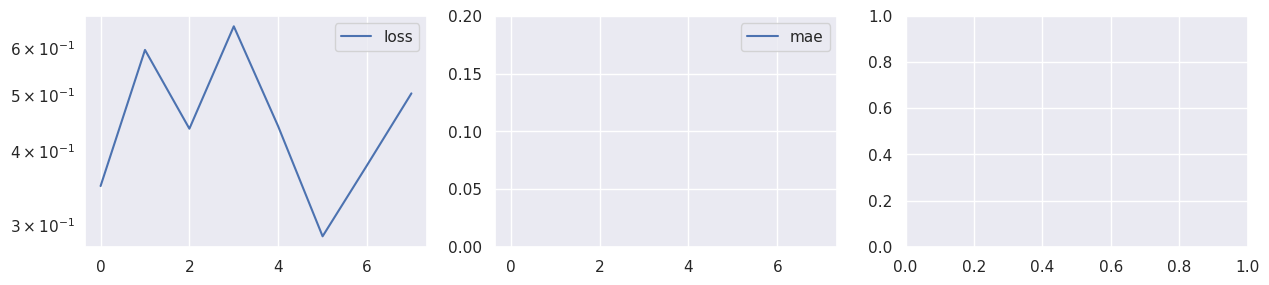

In [9]:
fig, axs = plt.subplots(1,3, figsize=(15,3))

sns.lineplot(data=run.history[["loss"]], ax=axs[0], dashes=False);
axs[0].set_yscale("log")

sns.lineplot(data=run.history[["mae"]], ax=axs[1], dashes=False);
axs[1].set_ylim(0,0.2)

#sns.lineplot(data=run.history[["lr"]], ax=axs[2], dashes=False);